# Module 8: 時間序列特徵工程 - 1. 滯後特徵 (Lag Features)

## 學習目標
- 理解滯後特徵的定義及其在時間序列分析中的根本重要性。
- 學習並實作如何使用 `pandas` 的 `.shift()` 方法創建不同時間步長的滯後特徵。
- 掌握如何處理滯後特徵引入的缺失值 (NaN)。
- 透過視覺化方法（時間序列圖、散點圖）觀察和理解時間序列的自相關性。
- 了解滯後特徵如何將時間依賴性顯式地納入機器學習模型，提升預測能力。

## 導論：如何讓機器學習模型「回顧」歷史以預測未來？

在時間序列資料分析中，一個最直觀且極其強大的特徵工程技術是創建 **滯後特徵 (Lag Features)**。時間序列資料的核心特性在於其強烈的「時間依賴性」或「自相關性 (Autocorrelation)」——即當前時間點的觀測值，往往與其過去時間點的觀測值存在著緊密的關聯。例如，今天的電力消耗量很可能與昨天、上週或去年同期的消耗量相似；一家商店今天的銷售額也深受昨天或上週同日銷售額的影響。

您的指南強調：「*時間序列資料的核心特性是時間依賴性...滯後特徵的作用就是將這種時間上的依賴關係明確地表示出來，讓機器學習模型能夠直接利用這些歷史資訊。*」這正是滯後特徵的精髓。大多數標準的機器學習模型（如線性回歸、決策樹）本身並不具備時間序列的感知能力，它們將每個觀測值視為獨立事件。如果沒有滯後特徵，這些模型將無法看到時間序列的歷史模式、趨勢或季節性。

滯後特徵正是解決這個問題的橋樑：它將過去時間點的觀測值（例如 `t-1`, `t-7` 時刻的銷售額）作為當前時間點 `t` 的新特徵。這樣一來，即使是普通的機器學習模型也能夠「回顧」歷史數據，並利用這些歷史模式來預測未來，從而顯著提升時間序列預測的準確性和穩定性。

### 為什麼滯後特徵至關重要？
1.  **捕捉時間依賴性**：直接將序列的自相關性呈現給模型，使模型能夠學習 `t` 時刻的行為如何受到 `t-n` 時刻行為的影響。
2.  **提升預測能力**：過去的資訊往往是預測未來的最佳指標，滯後特徵提供了這種直接的歷史上下文。
3.  **模型適用性廣泛**：使得非時間序列感知的機器學習模型也能有效處理時間序列數據。

---

## 1. 載入套件與資料

為了清晰地演示滯後特徵的創建過程，我們將首先創建一個簡單的模擬時間序列數據集。這個數據集將包含時間戳和一個模擬的數值序列（例如，銷售量或氣溫），足以展示如何從時間戳中提取各種有意義的時間組件，並將其轉化為模型可用的特徵。

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 創建一個簡單的模擬時間序列資料
data = {
    'date': pd.to_datetime(pd.date_range(start='2023-01-01', periods=10)),
    'sales': [20, 22, 25, 23, 28, 30, 29, 32, 35, 33]
}
df = pd.DataFrame(data)
df.set_index('date', inplace=True) # 將日期欄位設為索引，這是時間序列數據的常見做法

print("原始模擬時間序列資料載入成功！")
print("原始數據 (包含日期索引和銷售量)：")
display(df.head())



Matplotlib and Seaborn styles configured.
原始模擬時間序列資料載入成功！
原始數據 (包含日期索引和銷售量)：


,sales
date,
2023-01-01,20
2023-01-02,22
2023-01-03,25
2023-01-04,23
2023-01-05,28


**結果解讀**：

我們的模擬數據集包含日期索引和一系列的銷售數據。這是一個典型的時間序列格式，其中每個 `sales` 數值都與特定的日期相關聯。接下來，我們將利用這個序列來創建滯後特徵，模擬模型如何利用過去的銷售數據來預測未來的銷售。

## 2. 如何創建滯後特徵？ (`.shift()` 方法)

在 `pandas` 中，創建滯後特徵的核心工具是 DataFrame 或 Series 的 `.shift()` 方法。這個方法可以將序列中的數據向前或向後移動指定的位數。當參數為正數時（例如 `shift(1)`），它將數據向下移動，從而創建滯後特徵。

-   `df['column'].shift(1)`: 將 `column` 的數值向下移動一個時間單位，即將 `t-1` 時刻的值作為 `t` 時刻的特徵，這稱為「滯後 1 期特徵 (lag 1 feature)」。
-   `df['column'].shift(n)`: 創建一個滯後 n 期的特徵，將 `t-n` 時刻的值作為 `t` 時刻的特徵。

**注意**：`shift` 操作會導致在序列的開頭產生缺失值 (NaN)，因為在序列的開頭沒有足夠的歷史資料來填充這些新的滯後欄位。例如，滯後 1 期的特徵會在第一行產生 NaN，滯後 2 期的特徵會在前兩行產生 NaN。這些帶有 NaN 的行在將資料餵給機器學習模型之前通常需要被移除或進行插補。

In [8]:
print("正在創建滯後特徵...")
# 創建滯後 1 期特徵：t-1 的 sales 作為 t 時刻的特徵
df['sales_lag_1'] = df['sales'].shift(1)

# 創建滯後 2 期特徵：t-2 的 sales 作為 t 時刻的特徵
df['sales_lag_2'] = df['sales'].shift(2)

# 創建滯後 3 期特徵
df['sales_lag_3'] = df['sales'].shift(3)

print("滯後特徵創建完成！")
print("加入滯後特徵後的資料 (包含 NaN 值)：")
display(df.head(5)) # 顯示前5行，觀察 NaN 值



正在創建滯後特徵...
滯後特徵創建完成！
加入滯後特徵後的資料 (包含 NaN 值)：


,sales,sales_lag_1,sales_lag_2,sales_lag_3
date,,,,
2023-01-01,20,NaN,NaN,NaN
2023-01-02,22,20.0,NaN,NaN
2023-01-03,25,22.0,20.0,NaN
2023-01-04,23,25.0,22.0,20.0
2023-01-05,28,23.0,25.0,22.0


**結果解讀與討論**：

從結果中可以看到，`sales_lag_1` 的第一行是 NaN，因為在 2023-01-01 之前沒有前一天的銷售數據。同樣，`sales_lag_2` 的前兩行是 NaN，以此類推。在將這些特徵用於模型訓練之前，必須處理這些缺失值。最常見的處理方法是直接刪除這些包含 NaN 的行，因為它們缺乏完整的歷史信息。

### 2.1 處理滯後特徵產生的 NaN 值

為了確保模型能夠順利訓練，我們需要移除所有包含缺失值的行。這可以透過 `dropna()` 方法簡單實現。雖然這會損失部分最早的數據，但通常是可接受的權衡，以獲得完整的特徵集合。

In [9]:
print("正在移除滯後特徵產生的 NaN 值...")
df_cleaned = df.dropna()

print("NaN 值移除完成！")
print("移除 NaN 值後的資料：")
display(df_cleaned.head())
print(f"原始資料行數: {len(df)}, 清理後資料行數: {len(df_cleaned)}")



正在移除滯後特徵產生的 NaN 值...
NaN 值移除完成！
移除 NaN 值後的資料：


,sales,sales_lag_1,sales_lag_2,sales_lag_3
date,,,,
2023-01-04,23,25.0,22.0,20.0
2023-01-05,28,23.0,25.0,22.0
2023-01-06,30,28.0,23.0,25.0
2023-01-07,29,30.0,28.0,23.0
2023-01-08,32,29.0,30.0,28.0


原始資料行數: 10, 清理後資料行數: 7


**討論**：

清理後的數據集不再包含缺失值，可以被直接用於機器學習模型的訓練。請注意，在實際應用中，如果數據量較小且缺失值較多，移除行可能會導致信息損失過大。此時，可以考慮其他缺失值處理方法，例如對 NaN 值進行插補 (imputation)，但這需要謹慎，以避免數據洩漏（即用未來信息填充過去）。

## 3. 滯後特徵的視覺化：觀察時間依賴性

為了更直觀地理解滯後特徵與原始序列之間的關係，我們可以將它們繪製出來，並使用散點圖來觀察自相關性。這有助於確認時間序列的觀測值是否確實與其過去值存在相關性。

### 3.1 時間序列折線圖：直觀展示平移

將原始序列和各個滯後特徵繪製在同一張圖上，可以清晰地看到滯後特徵只是原始序列在時間軸上向右平移的結果。

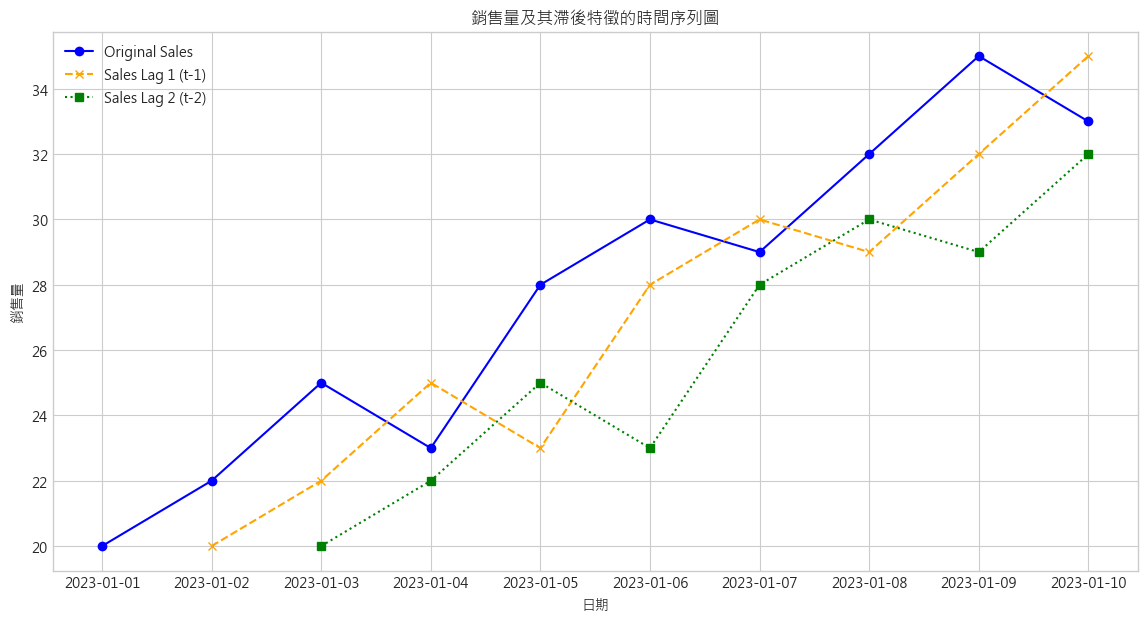

In [10]:
plt.figure(figsize=(14, 7))

# 原始序列
plt.plot(df.index, df['sales'], label='Original Sales', marker='o', linestyle='-', color='blue')

# Lag 1 特徵
plt.plot(df.index, df['sales_lag_1'], label='Sales Lag 1 (t-1)', marker='x', linestyle='--', color='orange')

# Lag 2 特徵
plt.plot(df.index, df['sales_lag_2'], label='Sales Lag 2 (t-2)', marker='s', linestyle=':', color='green')

plt.title('銷售量及其滯後特徵的時間序列圖')
plt.xlabel('日期')
plt.ylabel('銷售量')
plt.legend()
plt.grid(True)
plt.show()



**結果解讀**：

從折線圖中可以清楚地看到，`sales_lag_1` 和 `sales_lag_2` 曲線分別是原始 `sales` 曲線向右平移一個和兩個時間單位。這直觀地展示了滯後特徵是如何將過去的數據點帶到當前時間步長上，供模型使用。

### 3.2 散點圖：量化自相關性

散點圖是觀察兩個變數之間關係的有效工具。通過繪製當前值 (`sales` at `t`) 與其滯後值 (`sales` at `t-1` 或 `t-2`) 的散點圖，我們可以判斷它們之間是否存在線性相關性。如果點呈現出緊密的線性趨勢，就說明存在強烈的自相關性。

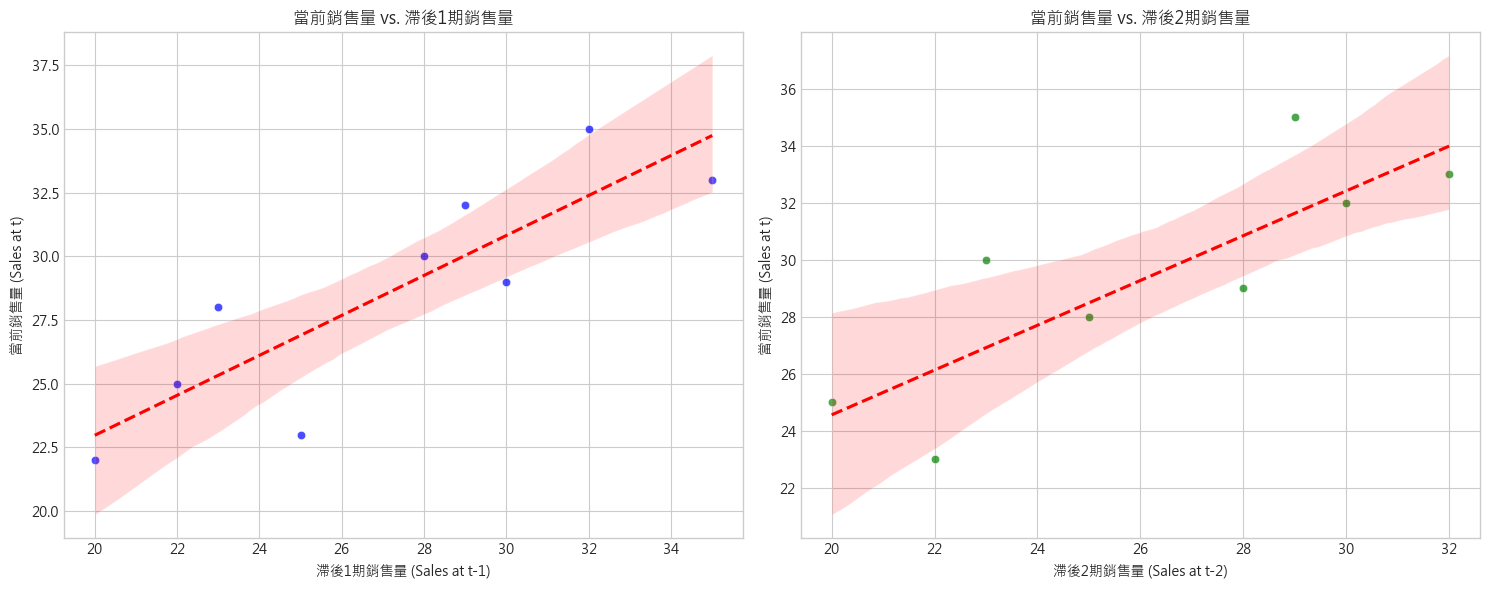

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Sales vs Lag 1 的散點圖，並添加回歸線以顯示趨勢
sns.scatterplot(data=df, x='sales_lag_1', y='sales', ax=ax1, color='blue', alpha=0.7)
sns.regplot(data=df, x='sales_lag_1', y='sales', ax=ax1, scatter=False, color='red', line_kws={'linestyle':'--'})
ax1.set_title('當前銷售量 vs. 滯後1期銷售量')
ax1.set_xlabel('滯後1期銷售量 (Sales at t-1)')
ax1.set_ylabel('當前銷售量 (Sales at t)')
ax1.grid(True)

# Sales vs Lag 2 的散點圖
sns.scatterplot(data=df, x='sales_lag_2', y='sales', ax=ax2, color='green', alpha=0.7)
sns.regplot(data=df, x='sales_lag_2', y='sales', ax=ax2, scatter=False, color='red', line_kws={'linestyle':'--'})
ax2.set_title('當前銷售量 vs. 滯後2期銷售量')
ax2.set_xlabel('滯後2期銷售量 (Sales at t-2)')
ax2.set_ylabel('當前銷售量 (Sales at t)')
ax2.grid(True)

plt.tight_layout()
plt.show()



**結果解讀**：

從左圖可以看出，`sales_lag_1` (即 `t-1` 時刻的銷售量) 和 `sales` (即 `t` 時刻的銷售量) 之間存在明顯的正相關關係，散點圖中的點大致沿著一條上升的直線分佈。這正是我們期望機器學習模型能夠學習到的核心模式。右圖顯示 `sales_lag_2` 與 `sales` 的相關性可能稍弱一些，但仍然存在。這些散點圖直觀地驗證了時間序列數據的自相關性，為使用滯後特徵提供了堅實的基礎。

## 4. 應用於真實資料集：電力消耗預測

現在，我們將所學的滯後特徵創建方法應用於一個真實的電力消耗資料集。我們將從 Kaggle 下載的 "Electric Power Consumption" 資料集中讀取部分數據，並為其創建滯後特徵，以模擬如何利用歷史電力消耗數據來預測未來。

**請注意**：此處預設資料檔案為 `household_power_consumption.txt`，請確保您已從 [Kaggle](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set) 下載並放置在 `../../datasets/raw/power_consumption/` 路徑下。

### 電力消耗資料集欄位中英文對照表與說明

| 英文欄位名稱            | 中文名稱         | 說明                                                         |
|-------------------------|------------------|--------------------------------------------------------------|
| Global_active_power     | 有效功率         | 家庭總有功功率（千瓦，kW），即實際消耗的電力                  |
| Global_reactive_power   | 無效功率         | 家庭總無功功率（千瓦，kW），即未被消耗、僅在電路中振盪的功率   |
| Voltage                | 電壓             | 家庭電壓（伏特，V）                                          |
| Global_intensity        | 電流強度         | 家庭總電流強度（安培，A）                                    |
| Sub_metering_1          | 子計量1          | 廚房相關電器（如洗碗機、烤箱、微波爐）消耗的能量（瓦時，Wh）   |
| Sub_metering_2          | 子計量2          | 洗衣房相關電器（如洗衣機、烘乾機、冰箱）消耗的能量（瓦時，Wh） |
| Sub_metering_3          | 子計量3          | 熱水器與空調消耗的能量（瓦時，Wh）                            |

**補充說明：**
- 有效功率（Global_active_power）是最常用於預測家庭總電力消耗的指標。
- 無效功率（Global_reactive_power）反映了電路中能量的儲存與釋放，對電力品質有影響。
- 子計量欄位（Sub_metering_1/2/3）可用於分析不同家電區域的用電行為。

In [22]:
# 資料路徑
# DATASET_PATH = '../../datasets/raw/power_consumption/AEP_hourly.csv' # 原始路徑，但實際提供的是txt
DATASET_PATH_TXT = r'..\..\..\..\datasets\raw\power_consumption\household_power_consumption.txt'
# 檢查資料是否存在
if not os.path.exists(DATASET_PATH_TXT):
    print(f"錯誤：找不到 '{DATASET_PATH_TXT}' 檔案。")
    print(f"請確認您已將資料下載至 '{os.path.abspath(DATASET_PATH_TXT)}'")
    # 創建一個空的 DataFrame 以避免後續錯誤
    df_power = pd.DataFrame() 
else:
    print(f"正在從 '{DATASET_PATH_TXT}' 載入電力消耗資料...")
    # 由於是大檔案且分隔符為分號，需要額外處理
    # low_memory=False 可以避免 dtype warning，但會增加記憶體使用
    # parse_dates=True 會嘗試解析日期列，na_values=['?'] 處理缺失值
    try:
        df_power_raw = pd.read_csv(
            DATASET_PATH_TXT, 
            sep=';', 
            parse_dates={'Datetime': ['Date', 'Time']},
            index_col='Datetime',
            na_values=['?'],
            low_memory=False
        )
        print("原始電力消耗資料載入成功！")

        # 選擇一個數值列並進行重採樣到日頻率，取均值
        # 因為原始資料可能很大且為每分鐘數據，為簡化示例我們使用每日數據
        # 選擇 Global_active_power 列作為分析對象
        if 'Global_active_power' in df_power_raw.columns:
            df_power_daily = df_power_raw['Global_active_power'].resample('D').mean().dropna()
            df_power_daily.rename('Consumption_kW', inplace=True)
            df_power = pd.DataFrame(df_power_daily)
            print("電力消耗資料已成功處理為每日平均值！")
            print("處理後資料集形狀:", df_power.shape)
            display(df_power.head())
        else:
            print("錯誤：'Global_active_power' 欄位不存在。將創建一個虛擬資料集。")
            date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
            dummy_data = np.random.randn(len(date_rng)).cumsum() + 350000
            df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
            print("虛擬資料集創建完成！")
    except Exception as e:
        print(f"載入或處理資料時發生錯誤: {e}。將創建一個虛擬資料集。")
        date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
        dummy_data = np.random.randn(len(date_rng)).cumsum() + 350000
        df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
        print("虛擬資料集創建完成！")

# 確保 df_power 不是空的，才進行後續操作
if not df_power.empty:
    # 創建多個滯後特徵 (例如，過去 7 天的電力消耗)
    for i in range(1, 8):
        df_power[f'consumption_lag_{i}'] = df_power['Consumption_kW'].shift(i)

    print("\n電力消耗資料集與其滯後特徵 (前5筆) 未移除因滯後操作產生的 NaN:")
    display(df_power.head())

    print("\n電力消耗資料集與其滯後特徵 (前5筆):")
    df_power.dropna(inplace=True) # 移除因滯後操作產生的 NaN
    display(df_power.head())

    print("\n最終資料集形狀:", df_power.shape)



正在從 '..\..\..\..\datasets\raw\power_consumption\household_power_consumption.txt' 載入電力消耗資料...


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_53188\4205918305.py:16: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_power_raw = pd.read_csv(


原始電力消耗資料載入成功！
電力消耗資料已成功處理為每日平均值！
處理後資料集形狀: (1433, 1)


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_53188\4205918305.py:16: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_power_raw = pd.read_csv(


,Consumption_kW
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658



電力消耗資料集與其滯後特徵 (前5筆) 未移除因滯後操作產生的 NaN:


,Consumption_kW,consumption_lag_1,consumption_lag_2,consumption_lag_3,consumption_lag_4,consumption_lag_5,consumption_lag_6,consumption_lag_7
Datetime,,,,,,,,
2006-12-16,3.053475,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-17,2.354486,3.053475,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-18,1.530435,2.354486,3.053475,NaN,NaN,NaN,NaN,NaN
2006-12-19,1.157079,1.530435,2.354486,3.053475,NaN,NaN,NaN,NaN
2006-12-20,1.545658,1.157079,1.530435,2.354486,3.053475,NaN,NaN,NaN



電力消耗資料集與其滯後特徵 (前5筆):


,Consumption_kW,consumption_lag_1,consumption_lag_2,consumption_lag_3,consumption_lag_4,consumption_lag_5,consumption_lag_6,consumption_lag_7
Datetime,,,,,,,,
2006-12-23,3.314851,1.625929,1.193758,1.545658,1.157079,1.530435,2.354486,3.053475
2006-12-24,1.770842,3.314851,1.625929,1.193758,1.545658,1.157079,1.530435,2.354486
2006-12-25,1.904944,1.770842,3.314851,1.625929,1.193758,1.545658,1.157079,1.530435
2006-12-26,2.732021,1.904944,1.770842,3.314851,1.625929,1.193758,1.545658,1.157079
2006-12-27,1.061639,2.732021,1.904944,1.770842,3.314851,1.625929,1.193758,1.545658



最終資料集形狀: (1426, 8)


**結果解讀與討論**：

在真實的電力消耗資料集上，我們成功地創建了多個滯後特徵。這些特徵代表了過去 1 到 7 天的平均電力消耗量。例如，`consumption_lag_1` 代表前一天的平均消耗，`consumption_lag_7` 代表前一週同天的平均消耗。這些滯後特徵將是預測未來電力消耗的關鍵輸入，因為電力消耗通常具有很強的日、週、月等週期性模式。透過這些歷史資訊，機器學習模型能夠更好地學習和捕捉這些複雜的時序規律。

## 5. 總結：滯後特徵在時間序列預測中的基石

滯後特徵是時間序列特徵工程中最基礎、也是最為重要的概念之一。它將時間序列固有的時間依賴性（自相關性）明確地轉化為機器學習模型可以直接利用的輸入變數，從而極大地提升了非序列感知模型在時間序列預測任務中的性能。

本節我們學習了以下關鍵點：

| 概念/方法 | 核心作用 | 實作工具/考量點 |
|:---|:---|:---|
| **滯後特徵** | 將過去觀測值作為當前時間步的預測依據 | `pandas.Series.shift()` | 
| **時間依賴性** | 序列數據的本質，當前值與過去值相關 | 透過折線圖和散點圖觀察自相關性 |
| **缺失值處理** | `shift()` 會產生 NaN 值，需清理 | `dropna()` (最常見) 或插補 (需謹慎，避免數據洩漏) |

在接下來的筆記本中，我們將在此基礎上，探索更多基於歷史資料的特徵構建方法，例如滑動窗口 (Rolling Windows) 來創建移動平均、移動標準差等統計特徵，進一步豐富時間序列的預測能力.


